#### Prepare SparkSession

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName('RDD Exercise') \
    .getOrCreate()
    
spark

#### Read the data

In [2]:
houses_data = spark.read \
  .csv('Sacramentorealestatetransactions.csv', header=True, inferSchema=True)

In [3]:
houses_data.rdd.getNumPartitions()

1

#### Save as parquet with partitioning by type of housing

In [4]:
houses_data.write.partitionBy('type').parquet('sacramentorealeastate')

AnalysisException: 'path file:/home/jovyan/work/sacramentorealeastate already exists.;'

#### Reload the data from parquet

In [5]:
houses_data = spark.read.parquet('sacramentorealeastate')

#### Repartition the data (e.g., use 10 partitions) - in this sample dataset not really worth doing, but definitely important when it comes to performance tuning in Spark

In [6]:
houses_data = houses_data.repartition(10).cache()

In [7]:
houses_data.rdd.getNumPartitions()

10

#### Take a short look at the data

In [8]:
houses_data.show(5, False)

+----------------+---------------+-----+-----+----+-----+------+----------------------------+------+---------+-----------+-----------+
|street          |city           |zip  |state|beds|baths|sq__ft|sale_date                   |price |latitude |longitude  |type       |
+----------------+---------------+-----+-----+----+-----+------+----------------------------+------+---------+-----------+-----------+
|374 1ST ST      |LINCOLN        |95648|CA   |0   |0    |0     |Mon May 19 00:00:00 EDT 2008|4897  |38.886525|-121.288787|Residential|
|3621 WINTUN DR  |CARMICHAEL     |95608|CA   |3   |2    |1655  |Fri May 16 00:00:00 EDT 2008|386222|38.629929|-121.323086|Residential|
|9552 SUNLIGHT LN|ELK GROVE      |95758|CA   |3   |2    |1351  |Fri May 16 00:00:00 EDT 2008|215000|38.410561|-121.404327|Residential|
|8284 RED FOX WAY|ELK GROVE      |95758|CA   |4   |2    |1685  |Tue May 20 00:00:00 EDT 2008|182000|38.417182|-121.397231|Residential|
|5031 CORVAIR ST |NORTH HIGHLANDS|95660|CA   |3   |2   

it is also possible to show it in pandas, it usually has nicer visualisations in notebooks - but be aware of the memory constraints (if you use pandas, it will only run on Spark's driver node)

In [9]:
houses_data.limit(5).toPandas()

,street,city,zip,state,beds,baths,sq__ft,sale_date,price,latitude,longitude,type
0,374 1ST ST,LINCOLN,95648,CA,0,0,0,Mon May 19 00:00:00 EDT 2008,4897,38.886525,-121.288787,Residential
1,3621 WINTUN DR,CARMICHAEL,95608,CA,3,2,1655,Fri May 16 00:00:00 EDT 2008,386222,38.629929,-121.323086,Residential
2,9552 SUNLIGHT LN,ELK GROVE,95758,CA,3,2,1351,Fri May 16 00:00:00 EDT 2008,215000,38.410561,-121.404327,Residential
3,8284 RED FOX WAY,ELK GROVE,95758,CA,4,2,1685,Tue May 20 00:00:00 EDT 2008,182000,38.417182,-121.397231,Residential
4,5031 CORVAIR ST,NORTH HIGHLANDS,95660,CA,3,2,1082,Wed May 21 00:00:00 EDT 2008,147308,38.658246,-121.375469,Residential


#### What does the dataset's schema look like (based on Spark's schema inference)?

In [10]:
houses_data.printSchema()

root
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- beds: integer (nullable = true)
 |-- baths: integer (nullable = true)
 |-- sq__ft: integer (nullable = true)
 |-- sale_date: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- type: string (nullable = true)



#### Get summary statistics for your data

In [11]:
houses_data.describe().toPandas()

,summary,street,city,zip,state,beds,baths,sq__ft,sale_date,price,latitude,longitude,type
0,count,985,985,985,985,985,985,985,985,985,985,985,985
1,mean,None,None,95750.69746192894,None,2.9116751269035532,1.7766497461928934,1314.9167512690356,None,234144.26395939087,38.60773208629442,-121.35598223553299,None
2,stddev,None,None,85.17607208451578,None,1.3079322320435816,0.8953714223186461,853.0482425034445,None,138365.839084928,0.14543287915297284,0.13827789978738936,None
3,min,1 KENNELFORD CIR,ANTELOPE,95603,CA,0,0,0,Fri May 16 00:00:00 EDT 2008,1551,38.241514,-121.551704,Condo
4,max,9970 STATE HIGHWAY 193,WILTON,95864,CA,8,5,5822,Wed May 21 00:00:00 EDT 2008,884790,39.020808,-120.597599,Unkown


#### How many houses do we have grouped by beds/baths/sqft?

In [12]:
houses_data.createOrReplaceTempView('houses_data')

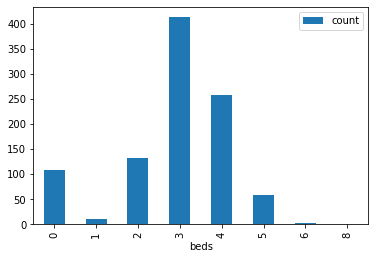

In [13]:
import matplotlib.pyplot as plt

# enable matplotlib inline to work with jupyter notebooks
%matplotlib inline


houses_data.groupBy("beds").count().sort('beds').toPandas().plot.bar(x='beds',y='count')

We could also do that with SQL queries

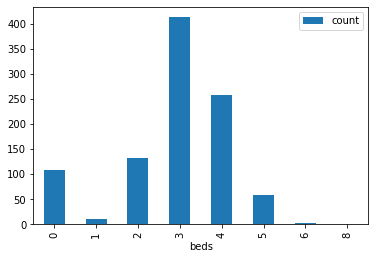

In [14]:
spark.sql('SELECT beds, COUNT(*) AS count FROM houses_data GROUP BY beds ORDER BY beds').toPandas().plot.bar(x='beds',y='count')

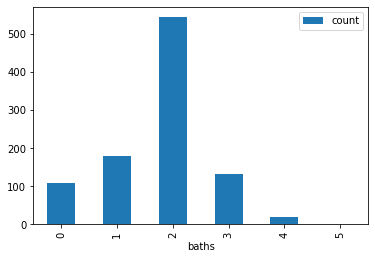

In [15]:
houses_data.groupBy("baths").count().sort('baths').toPandas().plot.bar(x='baths',y='count')

In [16]:
houses_data[houses_data.sq__ft == 0].count()

171

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f835b7f1cf8>]],
      dtype=object)

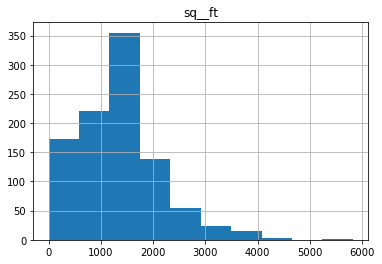

In [17]:
houses_data.select('sq__ft').toPandas().hist()

#### Convert sq__ft to square meters (do that by using the *withColumn* function and dividing that sq__ft by 10.764)

In [18]:
houses_data = houses_data.withColumn('square_meters', houses_data.sq__ft / 10.764)
houses_data.limit(10).toPandas()

,street,city,zip,state,beds,baths,sq__ft,sale_date,price,latitude,longitude,type,square_meters
0,374 1ST ST,LINCOLN,95648,CA,0,0,0,Mon May 19 00:00:00 EDT 2008,4897,38.886525,-121.288787,Residential,0.000000
1,3621 WINTUN DR,CARMICHAEL,95608,CA,3,2,1655,Fri May 16 00:00:00 EDT 2008,386222,38.629929,-121.323086,Residential,153.753252
2,9552 SUNLIGHT LN,ELK GROVE,95758,CA,3,2,1351,Fri May 16 00:00:00 EDT 2008,215000,38.410561,-121.404327,Residential,125.510962
3,8284 RED FOX WAY,ELK GROVE,95758,CA,4,2,1685,Tue May 20 00:00:00 EDT 2008,182000,38.417182,-121.397231,Residential,156.540320
4,5031 CORVAIR ST,NORTH HIGHLANDS,95660,CA,3,2,1082,Wed May 21 00:00:00 EDT 2008,147308,38.658246,-121.375469,Residential,100.520253
5,4250 ARDWELL WAY,SACRAMENTO,95823,CA,3,2,1089,Fri May 16 00:00:00 EDT 2008,95625,38.466938,-121.455631,Residential,101.170569
6,6121 ALPINESPRING WAY,ELK GROVE,95758,CA,3,2,1240,Fri May 16 00:00:00 EDT 2008,167293,38.434075,-121.432623,Residential,115.198811
7,8721 SPRUCE RIDGE WAY,ANTELOPE,95843,CA,3,2,1187,Mon May 19 00:00:00 EDT 2008,234000,38.727657,-121.391028,Residential,110.274991
8,8215 PEREGRINE WAY,CITRUS HEIGHTS,95610,CA,3,2,1401,Fri May 16 00:00:00 EDT 2008,305000,38.715493,-121.262930,Residential,130.156076
9,6932 RUSKUT WAY,SACRAMENTO,95823,CA,3,2,1477,Thu May 15 00:00:00 EDT 2008,234000,38.499893,-121.458890,Residential,137.216648


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f835b838668>]],
      dtype=object)

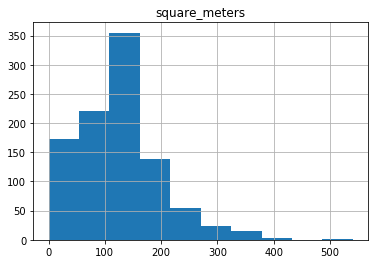

In [19]:
houses_data.select('square_meters').toPandas().hist()

## Now we try a simple regression, based on # of baths, # of beds, square meters, type of house
#### Since machine learning algorithms cannot deal with textual features, let's convert the type of house into  a numerical feature column using a *StringIndexer*

In [20]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol='type', outputCol='type_index')
houses_data = indexer.fit(houses_data).transform(houses_data)
houses_data.limit(10).toPandas()

,street,city,zip,state,beds,baths,sq__ft,sale_date,price,latitude,longitude,type,square_meters,type_index
0,374 1ST ST,LINCOLN,95648,CA,0,0,0,Mon May 19 00:00:00 EDT 2008,4897,38.886525,-121.288787,Residential,0.000000,0.0
1,3621 WINTUN DR,CARMICHAEL,95608,CA,3,2,1655,Fri May 16 00:00:00 EDT 2008,386222,38.629929,-121.323086,Residential,153.753252,0.0
2,9552 SUNLIGHT LN,ELK GROVE,95758,CA,3,2,1351,Fri May 16 00:00:00 EDT 2008,215000,38.410561,-121.404327,Residential,125.510962,0.0
3,8284 RED FOX WAY,ELK GROVE,95758,CA,4,2,1685,Tue May 20 00:00:00 EDT 2008,182000,38.417182,-121.397231,Residential,156.540320,0.0
4,5031 CORVAIR ST,NORTH HIGHLANDS,95660,CA,3,2,1082,Wed May 21 00:00:00 EDT 2008,147308,38.658246,-121.375469,Residential,100.520253,0.0
5,4250 ARDWELL WAY,SACRAMENTO,95823,CA,3,2,1089,Fri May 16 00:00:00 EDT 2008,95625,38.466938,-121.455631,Residential,101.170569,0.0
6,6121 ALPINESPRING WAY,ELK GROVE,95758,CA,3,2,1240,Fri May 16 00:00:00 EDT 2008,167293,38.434075,-121.432623,Residential,115.198811,0.0
7,8721 SPRUCE RIDGE WAY,ANTELOPE,95843,CA,3,2,1187,Mon May 19 00:00:00 EDT 2008,234000,38.727657,-121.391028,Residential,110.274991,0.0
8,8215 PEREGRINE WAY,CITRUS HEIGHTS,95610,CA,3,2,1401,Fri May 16 00:00:00 EDT 2008,305000,38.715493,-121.262930,Residential,130.156076,0.0
9,6932 RUSKUT WAY,SACRAMENTO,95823,CA,3,2,1477,Thu May 15 00:00:00 EDT 2008,234000,38.499893,-121.458890,Residential,137.216648,0.0


#### Filter invalid rows (e.g., # of beds/baths and square_meters is 0)

In [21]:
houses_data = houses_data[(houses_data.beds > 0) & (houses_data.baths > 0) & (houses_data.square_meters > 0)]
houses_data.limit(10).toPandas()

,street,city,zip,state,beds,baths,sq__ft,sale_date,price,latitude,longitude,type,square_meters,type_index
0,3621 WINTUN DR,CARMICHAEL,95608,CA,3,2,1655,Fri May 16 00:00:00 EDT 2008,386222,38.629929,-121.323086,Residential,153.753252,0.0
1,9552 SUNLIGHT LN,ELK GROVE,95758,CA,3,2,1351,Fri May 16 00:00:00 EDT 2008,215000,38.410561,-121.404327,Residential,125.510962,0.0
2,8284 RED FOX WAY,ELK GROVE,95758,CA,4,2,1685,Tue May 20 00:00:00 EDT 2008,182000,38.417182,-121.397231,Residential,156.540320,0.0
3,5031 CORVAIR ST,NORTH HIGHLANDS,95660,CA,3,2,1082,Wed May 21 00:00:00 EDT 2008,147308,38.658246,-121.375469,Residential,100.520253,0.0
4,4250 ARDWELL WAY,SACRAMENTO,95823,CA,3,2,1089,Fri May 16 00:00:00 EDT 2008,95625,38.466938,-121.455631,Residential,101.170569,0.0
5,6121 ALPINESPRING WAY,ELK GROVE,95758,CA,3,2,1240,Fri May 16 00:00:00 EDT 2008,167293,38.434075,-121.432623,Residential,115.198811,0.0
6,8721 SPRUCE RIDGE WAY,ANTELOPE,95843,CA,3,2,1187,Mon May 19 00:00:00 EDT 2008,234000,38.727657,-121.391028,Residential,110.274991,0.0
7,8215 PEREGRINE WAY,CITRUS HEIGHTS,95610,CA,3,2,1401,Fri May 16 00:00:00 EDT 2008,305000,38.715493,-121.262930,Residential,130.156076,0.0
8,6932 RUSKUT WAY,SACRAMENTO,95823,CA,3,2,1477,Thu May 15 00:00:00 EDT 2008,234000,38.499893,-121.458890,Residential,137.216648,0.0
9,104 CATLIN CT,FOLSOM,95630,CA,4,3,2660,Mon May 19 00:00:00 EDT 2008,636000,38.684459,-121.145935,Residential,247.120030,0.0


#### Select the relevant features from the dataframe

In [22]:
houses_data = houses_data[['beds', 'baths', 'square_meters', 'type_index', 'price']]

#### Assemble the training features into a vector (needed for MLlib in PySpark) using the *VectorAssembler*

In [23]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['beds', 'baths', 'square_meters', 'type_index'], outputCol='features')
prep_houses_data = assembler.transform(houses_data)

In [24]:
prep_houses_data.limit(10).toPandas()

,beds,baths,square_meters,type_index,price,features
0,3,2,153.753252,0.0,386222,"[3.0, 2.0, 153.75325157933855, 0.0]"
1,3,2,125.510962,0.0,215000,"[3.0, 2.0, 125.51096246748422, 0.0]"
2,4,2,156.540320,0.0,182000,"[4.0, 2.0, 156.54031958379787, 0.0]"
3,3,2,100.520253,0.0,147308,"[3.0, 2.0, 100.52025269416575, 0.0]"
4,3,2,101.170569,0.0,95625,"[3.0, 2.0, 101.17056856187291, 0.0]"
5,3,2,115.198811,0.0,167293,"[3.0, 2.0, 115.19881085098477, 0.0]"
6,3,2,110.274991,0.0,234000,"[3.0, 2.0, 110.27499070977332, 0.0]"
7,3,2,130.156076,0.0,305000,"[3.0, 2.0, 130.15607580824974, 0.0]"
8,3,2,137.216648,0.0,234000,"[3.0, 2.0, 137.21664808621333, 0.0]"
9,4,3,247.120030,0.0,636000,"[4.0, 3.0, 247.1200297287254, 0.0]"


In [25]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
prep_houses_data = scaler.fit(prep_houses_data).transform(prep_houses_data)
prep_houses_data.limit(10).toPandas()

,beds,baths,square_meters,type_index,price,features,scaledFeatures
0,3,2,153.753252,0.0,386222,"[3.0, 2.0, 153.75325157933855, 0.0]","[3.5205595805303584, 2.9859489065199343, 2.493..."
1,3,2,125.510962,0.0,215000,"[3.0, 2.0, 125.51096246748422, 0.0]","[3.5205595805303584, 2.9859489065199343, 2.035..."
2,4,2,156.540320,0.0,182000,"[4.0, 2.0, 156.54031958379787, 0.0]","[4.694079440707145, 2.9859489065199343, 2.5382..."
3,3,2,100.520253,0.0,147308,"[3.0, 2.0, 100.52025269416575, 0.0]","[3.5205595805303584, 2.9859489065199343, 1.629..."
4,3,2,101.170569,0.0,95625,"[3.0, 2.0, 101.17056856187291, 0.0]","[3.5205595805303584, 2.9859489065199343, 1.640..."
5,3,2,115.198811,0.0,167293,"[3.0, 2.0, 115.19881085098477, 0.0]","[3.5205595805303584, 2.9859489065199343, 1.867..."
6,3,2,110.274991,0.0,234000,"[3.0, 2.0, 110.27499070977332, 0.0]","[3.5205595805303584, 2.9859489065199343, 1.788..."
7,3,2,130.156076,0.0,305000,"[3.0, 2.0, 130.15607580824974, 0.0]","[3.5205595805303584, 2.9859489065199343, 2.110..."
8,3,2,137.216648,0.0,234000,"[3.0, 2.0, 137.21664808621333, 0.0]","[3.5205595805303584, 2.9859489065199343, 2.224..."
9,4,3,247.120030,0.0,636000,"[4.0, 3.0, 247.1200297287254, 0.0]","[4.694079440707145, 4.478923359779902, 4.00697..."


#### Now build the regression model

In [26]:
from pyspark.ml.regression import LinearRegression

train, test = prep_houses_data.randomSplit([.8,.2], seed=0)
lr = LinearRegression(featuresCol='scaledFeatures', labelCol='price')

lrModel = lr.fit(train)

print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))
trainingSummary = lrModel.summary

Coefficients: [-8866.31347392942,1229.2337232287584,85465.06687599716,-9544.930279760518]
Intercept: 56369.839887420036


In [27]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

numIterations: 1
objectiveHistory: [0.0]
RMSE: 87582.290724
r2: 0.486742


In [28]:
lr_predictions = lrModel.transform(test)
lr_predictions.select(['prediction', 'price', 'scaledFeatures']).limit(10).toPandas()

,prediction,price,scaledFeatures
0,110786.801525,116250,"[2.3470397203535724, 1.4929744532599671, 1.197..."
1,151719.335898,101000,"[2.3470397203535724, 1.4929744532599671, 1.337..."
2,170806.125627,108750,"[2.3470397203535724, 2.9859489065199343, 1.539..."
3,293231.397038,460000,"[3.5205595805303584, 1.4929744532599671, 3.115..."
4,152419.258579,155000,"[3.5205595805303584, 2.9859489065199343, 1.446..."
5,169027.118270,95625,"[3.5205595805303584, 2.9859489065199343, 1.640..."
6,173018.154320,209000,"[3.5205595805303584, 2.9859489065199343, 1.687..."
7,183832.574584,174000,"[3.5205595805303584, 2.9859489065199343, 1.813..."
8,202757.810045,215000,"[3.5205595805303584, 2.9859489065199343, 2.035..."
9,206491.359898,265000,"[3.5205595805303584, 2.9859489065199343, 2.078..."


#### Evaluate the model's performance on the test data

In [29]:
from pyspark.ml.evaluation import RegressionEvaluator

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="price",metricName="r2")

print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.5076
